**Image Classification of Stellar Objects**


**Introduction:** Provide an overview of the
chosen dataset, along with the scientific motivation for analyzing it.

<br>	With the expansion of data collection and storage options, the field of observational astronomy and astrophysics are increasingly inundated with large amounts of data. Projects like the Hubble, James Web, and Sloan Digital Sky Survey can collect millions of images within a relatively short frame of time. Conventional techniques could greatly limit scientific potential. Machine Learning models allow scientists to work with large volumes of imaging data more efficiently.<br>
	A classic problem is categorization of stars vs galaxies. Star images can have the appearance of “point spread” when observed through the earth’s atmosphere, while images of galaxies taken from a great distance can resemble stars. With the vast amounts of images “the task would take simply too long for large data sets, and therefore there is a very good case for the use of ML (Kembhavi et al 2020).”<br>   To explore this problem, data from the Aryabhatta Research Institute of Observational Sciences (ARIES), Nainital, India (Agrawal 2021) is explored. The images are given in 64x64 cutouts and represent real-word observations of stars and galaxies. There are a total of 3044 stars and 942 galaxies within the dataset (N = 3986), with an approximately 76%/24% split between stars and galaxies. The images were labeled, reformatted, and normalized then spit into a training (80%) and validation (20%) dataset, with both having the same representation of stars and galaxies.
.
.
s.


**Data Set-up**

In [1]:
##Loading packages

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
from PIL import Image
import sys
from tensorflow.keras.utils import to_categorical
import glob


galaxy_dataset_dir = glob.glob('/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/*')
star_dataset_dir = glob.glob('/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/star/*')

#Creating data frames for the stars and galaxy
data = []
labels = []
for x in galaxy_dataset_dir:
    print(x)
    image = Image.open(x)
    image= np.array(image)
    data.append(image)
    labels.append(0)
for x in star_dataset_dir:
    image = Image.open(x)
    image= np.array(image)
    data.append(image)
    labels.append(1) 

data, labels= np.array(data), np.array(labels)


/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J125219p264053_001_010_848_237_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J153044p231014_001_001_234_1473_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J142943p385931_001_001_491_1223_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J125219p264053_001_010_334_652_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J1603p3002_001_010_1557_556_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J1530p2310_r_01_943_466_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J1530p2310_r_01_111_624_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J1603p3002_001_010_215_1708_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J142943p385931_001_001_787_1722_3.jpg
/Users/valerier/Desktop/CSU/Machine Learning/Cutout Files/galaxy/J142943p385931_001_001_778_836_3.j

In [3]:
#organizing data into one dataframe and splitting into training and test images
full_dataset= pd.DataFrame(list(zip(data, labels)), columns=['images','labels'])

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42, shuffle=True,stratify=full_dataset['labels'].values)

In [4]:
x_train.shape

(3188, 64, 64, 3)

In [5]:
x_test.shape

(798, 64, 64, 3)

In [6]:
y_train.shape

(3188,)

In [7]:
y_test.shape

(798,)

In [8]:
#normalization
x_train=x_train/255
x_test=x_test/255

[ 753 2435]


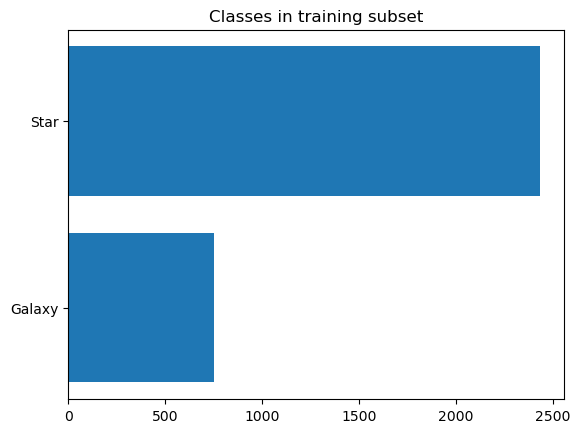

In [9]:
#Looking at the breakdown of Stars and Galaxies
import matplotlib.pyplot as plt

class_name = ['Galaxy', 'Star']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(class_name, counts)
plt.title('Classes in training subset')
print(counts)

[189 609]


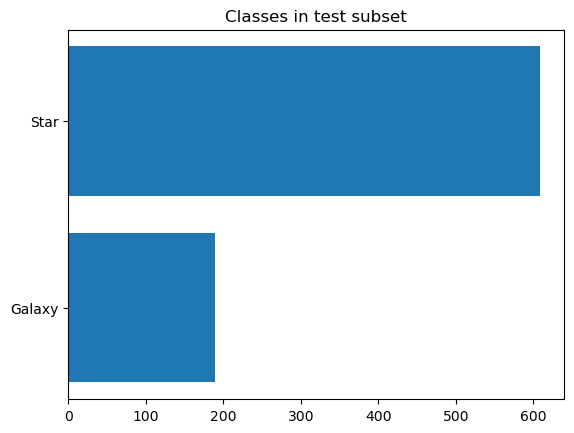

In [10]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(class_name, counts)
plt.title('Classes in test subset')
print(counts)

**Method:** Specify the model
you use, including the details of hyperparameter choice and tuning. 

A recent overview of applications of Machine Learning in Astronomy note the use of methods such as logistic regression, k-nearest neighbors and random forests as satisfactory alternatives to the potentially more time-consuming and computationally expensive deep learning methods (Kembavi et al 2022). There is specific discussion of Random Forests and and Convolution Neural Network(CNN) for classification of stellar objects. As such, both were fit to explore their relative merits, with the Random forest serving as a "shallow" baseline. Since CNNs are “a type of deep-learning model almost universally used in computer vision applications (Chollet 2017)” with the ability to learn spatial features, this is the natural choice for classification of images.

**Random Forest**

In [11]:
# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz



In [12]:
# reshape the array (4d to 2d)
nsamples, nx, ny, nrgb = x_train.shape
x_train_rf = x_train.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = x_test.shape
x_test_rf = x_test.reshape((nsamples,nx*ny*nrgb))

In [13]:
rf = RandomForestClassifier()
rf.fit(x_train_rf, y_train)
y_pred = rf.predict(x_test_rf)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7807017543859649


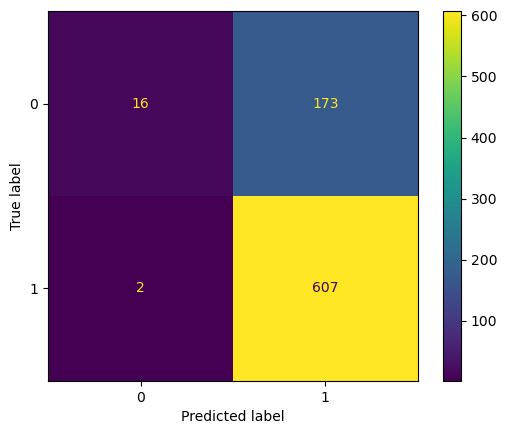

In [15]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()


In [31]:
param_dist = {'n_estimators': [50,100,500],
                'max_depth': [3,5,10,15]}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train_rf, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [3, 5, 10, 15],
                                        'n_estimators': [50, 100, 500]})

In [34]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 50, 'max_depth': 15}


In [16]:
rf = RandomForestClassifier(
    n_estimators = 50,
    max_depth=15
)
rf.fit(x_train_rf, y_train)
y_pred = rf.predict(x_test_rf)

In [17]:
y_pred = rf.predict(x_test_rf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7832080200501254


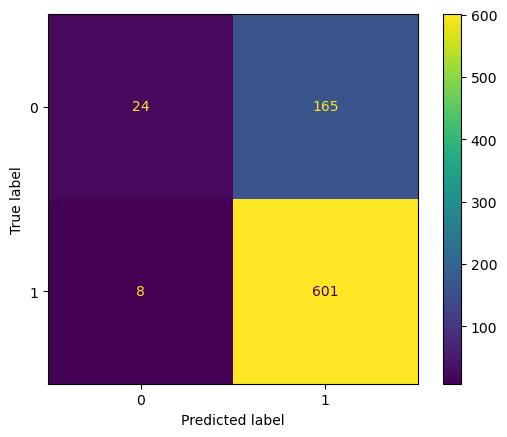

In [19]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

**Image Classification using CNN**

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import models


model = keras.models.Sequential()
#inputs = keras.Input()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64,64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))



In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Adding a classifier layer
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,273 (2.47 MB)

 Trainable params: 646,273 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
        keras.metrics.FalsePositives(),])

history = model.fit(x_train, y_train, epochs=10, 
         validation_data =(x_test,y_test))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - binary_accuracy: 0.9312 - false_negatives_1: 37.0594 - false_positives_1: 72.0396 - loss: 0.1992 - val_binary_accuracy: 0.8747 - val_false_negatives_1: 36.0000 - val_false_positives_1: 64.0000 - val_loss: 0.3063
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_accuracy: 0.9284 - false_negatives_1: 43.5149 - false_positives_1: 65.7228 - loss: 0.1786 - val_binary_accuracy: 0.8622 - val_false_negatives_1: 67.0000 - val_false_positives_1: 43.0000 - val_loss: 0.3191
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_accuracy: 0.9591 - false_negatives_1: 28.8416 - false_positives_1: 39.0891 - loss: 0.1250 - val_binary_accuracy: 0.8647 - val_false_negatives_1: 56.0000 - val_false_positives_1: 52.0000 - val_loss: 0.3241
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_accuracy: 0.9562 - false_negatives_1: 28.7030 - false_positives_1: 45.9307 - loss: 0.1297 - val_binary_accuracy: 0.8672 - val_false_negat

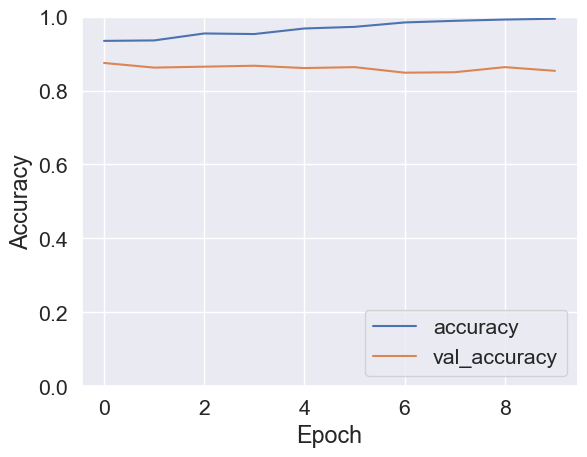

In [34]:
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')



In [35]:
import matplotlib.pyplot as plt
accuracy = history.history["binary_accuracy"]
val_accuracy = history.history["val_binary_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

false_pos= history.history["false_positives"]
val_false_pos = history.history["val_false_positives"]

false_neg = history.history["false_negatives"]
val_false_neg = history.history["val_false_negatives"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()
plt.plot(epochs, false_pos, "bo", label="Training False Positives")
plt.plot(epochs, val_false_pos, "b", label="Validation False Positives")
plt.title("Training and validation false positives")
plt.legend()
plt.figure()
plt.plot(epochs, false_neg, "bo", label="Training False Negatives")
plt.plot(epochs, val_false_neg, "b", label="Validation False Negatives")
plt.title("Training and validation false negatives")
plt.legend()
plt.show()

KeyError: 'false_positives'

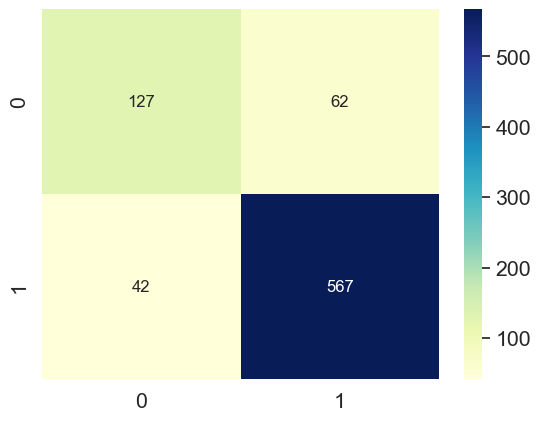

In [36]:
#Creating confusion matrix from false pos/neg values had trouble plotting as above
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[127,62],
         [42,567]]

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt = 'd',cmap="YlGnBu") # font size

plt.show()


**Fine-tuning CNN**

In [38]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

r = model.fit(train_generator, 
              epochs=30,
              steps_per_epoch=steps_per_epoch,
              validation_data=(x_test, y_test), 
             )


Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - binary_accuracy: 0.8724 - false_negatives_1: 76.2100 - false_positives_1: 127.7900 - loss: 0.3107 - val_binary_accuracy: 0.8571 - val_false_negatives_1: 73.0000 - val_false_positives_1: 41.0000 - val_loss: 0.3136
Epoch 2/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.8125 - false_negatives_1: 3.0000 - false_positives_1: 3.0000 - loss: 0.3120

2024-05-07 12:26:06.632550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8125 - false_negatives_1: 3.0000 - false_positives_1: 3.0000 - loss: 0.3120 - val_binary_accuracy: 0.8697 - val_false_negatives_1: 55.0000 - val_false_positives_1: 49.0000 - val_loss: 0.3017
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - binary_accuracy: 0.8694 - false_negatives_1: 74.7800 - false_positives_1: 133.5200 - loss: 0.3193 - val_binary_accuracy: 0.8734 - val_false_negatives_1: 51.0000 - val_false_positives_1: 50.0000 - val_loss: 0.2963
Epoch 4/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - binary_accuracy: 0.7812 - false_negatives_1: 3.0000 - false_positives_1: 4.0000 - loss: 0.2999

2024-05-07 12:26:10.131452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7812 - false_negatives_1: 3.0000 - false_positives_1: 4.0000 - loss: 0.2999 - val_binary_accuracy: 0.8772 - val_false_negatives_1: 48.0000 - val_false_positives_1: 50.0000 - val_loss: 0.2972
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - binary_accuracy: 0.8678 - false_negatives_1: 78.4700 - false_positives_1: 130.6600 - loss: 0.3109 - val_binary_accuracy: 0.8622 - val_false_negatives_1: 72.0000 - val_false_positives_1: 38.0000 - val_loss: 0.2983
Epoch 6/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.9062 - false_negatives_1: 0.0000e+00 - false_positives_1: 3.0000 - loss: 0.2980

2024-05-07 12:26:13.518072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9062 - false_negatives_1: 0.0000e+00 - false_positives_1: 3.0000 - loss: 0.2980 - val_binary_accuracy: 0.8747 - val_false_negatives_1: 58.0000 - val_false_positives_1: 42.0000 - val_loss: 0.2933
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.8837 - false_negatives_1: 77.1000 - false_positives_1: 116.3100 - loss: 0.2915 - val_binary_accuracy: 0.8784 - val_false_negatives_1: 50.0000 - val_false_positives_1: 47.0000 - val_loss: 0.2894
Epoch 8/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.8750 - false_negatives_1: 1.0000 - false_positives_1: 3.0000 - loss: 0.4865

2024-05-07 12:26:16.820863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8750 - false_negatives_1: 1.0000 - false_positives_1: 3.0000 - loss: 0.4865 - val_binary_accuracy: 0.8784 - val_false_negatives_1: 52.0000 - val_false_positives_1: 45.0000 - val_loss: 0.2930
Epoch 9/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - binary_accuracy: 0.8679 - false_negatives_1: 81.0400 - false_positives_1: 120.8000 - loss: 0.3038 - val_binary_accuracy: 0.8860 - val_false_negatives_1: 45.0000 - val_false_positives_1: 46.0000 - val_loss: 0.2851
Epoch 10/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.8750 - false_negatives_1: 1.0000 - false_positives_1: 3.0000 - loss: 0.2310

2024-05-07 12:26:20.058433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8750 - false_negatives_1: 1.0000 - false_positives_1: 3.0000 - loss: 0.2310 - val_binary_accuracy: 0.8847 - val_false_negatives_1: 45.0000 - val_false_positives_1: 47.0000 - val_loss: 0.2859
Epoch 11/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.8737 - false_negatives_1: 73.8500 - false_positives_1: 121.9400 - loss: 0.3045 - val_binary_accuracy: 0.8709 - val_false_negatives_1: 62.0000 - val_false_positives_1: 41.0000 - val_loss: 0.2909
Epoch 12/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - binary_accuracy: 0.8125 - false_negatives_1: 3.0000 - false_positives_1: 3.0000 - loss: 0.3102

2024-05-07 12:26:23.446208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8125 - false_negatives_1: 3.0000 - false_positives_1: 3.0000 - loss: 0.3102 - val_binary_accuracy: 0.8634 - val_false_negatives_1: 73.0000 - val_false_positives_1: 36.0000 - val_loss: 0.3027
Epoch 13/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - binary_accuracy: 0.8782 - false_negatives_1: 75.7400 - false_positives_1: 119.5500 - loss: 0.2821 - val_binary_accuracy: 0.8747 - val_false_negatives_1: 58.0000 - val_false_positives_1: 42.0000 - val_loss: 0.3015
Epoch 14/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - binary_accuracy: 0.9062 - false_negatives_1: 1.0000 - false_positives_1: 2.0000 - loss: 0.2605

2024-05-07 12:26:26.824175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9062 - false_negatives_1: 1.0000 - false_positives_1: 2.0000 - loss: 0.2605 - val_binary_accuracy: 0.8722 - val_false_negatives_1: 38.0000 - val_false_positives_1: 64.0000 - val_loss: 0.2881
Epoch 15/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - binary_accuracy: 0.8795 - false_negatives_1: 66.2100 - false_positives_1: 123.6200 - loss: 0.2971 - val_binary_accuracy: 0.8784 - val_false_negatives_1: 20.0000 - val_false_positives_1: 77.0000 - val_loss: 0.2950
Epoch 16/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.8125 - false_negatives_1: 1.0000 - false_positives_1: 5.0000 - loss: 0.5121

2024-05-07 12:26:30.241113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8125 - false_negatives_1: 1.0000 - false_positives_1: 5.0000 - loss: 0.5121 - val_binary_accuracy: 0.8784 - val_false_negatives_1: 21.0000 - val_false_positives_1: 76.0000 - val_loss: 0.2901
Epoch 17/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - binary_accuracy: 0.8959 - false_negatives_1: 67.5700 - false_positives_1: 105.5500 - loss: 0.2540 - val_binary_accuracy: 0.8634 - val_false_negatives_1: 71.0000 - val_false_positives_1: 38.0000 - val_loss: 0.3036
Epoch 18/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.8750 - false_negatives_1: 2.0000 - false_positives_1: 2.0000 - loss: 0.2509

2024-05-07 12:26:33.508231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8750 - false_negatives_1: 2.0000 - false_positives_1: 2.0000 - loss: 0.2509 - val_binary_accuracy: 0.8609 - val_false_negatives_1: 72.0000 - val_false_positives_1: 39.0000 - val_loss: 0.3033
Epoch 19/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - binary_accuracy: 0.8785 - false_negatives_1: 72.3900 - false_positives_1: 120.3100 - loss: 0.2813 - val_binary_accuracy: 0.8947 - val_false_negatives_1: 21.0000 - val_false_positives_1: 63.0000 - val_loss: 0.2825
Epoch 20/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.9062 - false_negatives_1: 0.0000e+00 - false_positives_1: 3.0000 - loss: 0.5155

2024-05-07 12:26:36.751754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9062 - false_negatives_1: 0.0000e+00 - false_positives_1: 3.0000 - loss: 0.5155 - val_binary_accuracy: 0.8947 - val_false_negatives_1: 20.0000 - val_false_positives_1: 64.0000 - val_loss: 0.2861
Epoch 21/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.8863 - false_negatives_1: 70.0300 - false_positives_1: 116.3900 - loss: 0.2729 - val_binary_accuracy: 0.8684 - val_false_negatives_1: 61.0000 - val_false_positives_1: 44.0000 - val_loss: 0.3048
Epoch 22/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.9062 - false_negatives_1: 2.0000 - false_positives_1: 1.0000 - loss: 0.2639

2024-05-07 12:26:40.109025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9062 - false_negatives_1: 2.0000 - false_positives_1: 1.0000 - loss: 0.2639 - val_binary_accuracy: 0.8722 - val_false_negatives_1: 52.0000 - val_false_positives_1: 50.0000 - val_loss: 0.2923
Epoch 23/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.8900 - false_negatives_1: 68.2500 - false_positives_1: 109.9900 - loss: 0.2722 - val_binary_accuracy: 0.8822 - val_false_negatives_1: 41.0000 - val_false_positives_1: 53.0000 - val_loss: 0.2817
Epoch 24/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - binary_accuracy: 0.9062 - false_negatives_1: 1.0000 - false_positives_1: 2.0000 - loss: 0.1604

2024-05-07 12:26:43.434094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9062 - false_negatives_1: 1.0000 - false_positives_1: 2.0000 - loss: 0.1604 - val_binary_accuracy: 0.8885 - val_false_negatives_1: 37.0000 - val_false_positives_1: 52.0000 - val_loss: 0.2806
Epoch 25/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.8859 - false_negatives_1: 69.2600 - false_positives_1: 116.1000 - loss: 0.2578 - val_binary_accuracy: 0.8897 - val_false_negatives_1: 37.0000 - val_false_positives_1: 51.0000 - val_loss: 0.2763
Epoch 26/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - binary_accuracy: 0.7500 - false_negatives_1: 2.0000 - false_positives_1: 6.0000 - loss: 0.4846

2024-05-07 12:26:46.744876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7500 - false_negatives_1: 2.0000 - false_positives_1: 6.0000 - loss: 0.4846 - val_binary_accuracy: 0.8897 - val_false_negatives_1: 41.0000 - val_false_positives_1: 47.0000 - val_loss: 0.2768
Epoch 27/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.8920 - false_negatives_1: 72.5300 - false_positives_1: 106.0900 - loss: 0.2538 - val_binary_accuracy: 0.8759 - val_false_negatives_1: 64.0000 - val_false_positives_1: 35.0000 - val_loss: 0.2876
Epoch 28/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.9062 - false_negatives_1: 2.0000 - false_positives_1: 1.0000 - loss: 0.2744

2024-05-07 12:26:50.030504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9062 - false_negatives_1: 2.0000 - false_positives_1: 1.0000 - loss: 0.2744 - val_binary_accuracy: 0.8759 - val_false_negatives_1: 67.0000 - val_false_positives_1: 32.0000 - val_loss: 0.2907
Epoch 29/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - binary_accuracy: 0.8915 - false_negatives_1: 72.8700 - false_positives_1: 106.9200 - loss: 0.2683 - val_binary_accuracy: 0.8885 - val_false_negatives_1: 38.0000 - val_false_positives_1: 51.0000 - val_loss: 0.2692
Epoch 30/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - binary_accuracy: 0.8000 - false_negatives_1: 2.0000 - false_positives_1: 2.0000 - loss: 0.3113

2024-05-07 12:26:53.299323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8000 - false_negatives_1: 2.0000 - false_positives_1: 2.0000 - loss: 0.3113 - val_binary_accuracy: 0.8835 - val_false_negatives_1: 48.0000 - val_false_positives_1: 45.0000 - val_loss: 0.2731


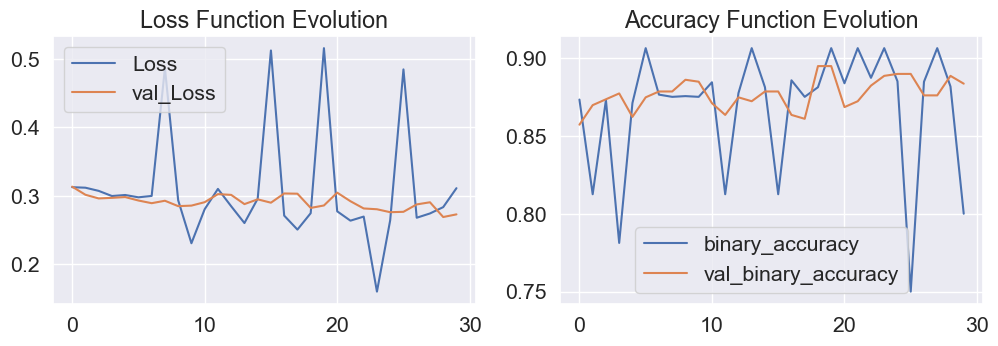

In [40]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['binary_accuracy'], label='binary_accuracy')
plt.plot(r.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()


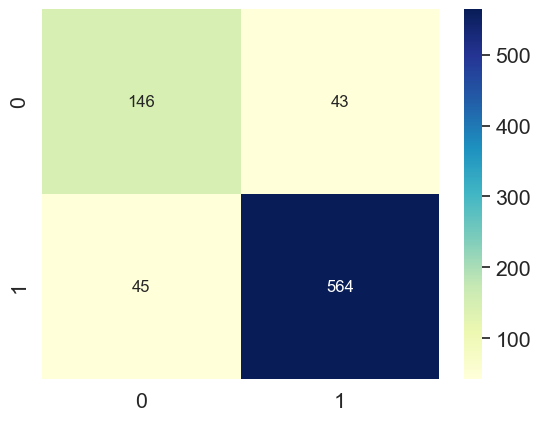

In [41]:
#Creating confusion matrix from false pos/neg values had trouble plotting as above
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[146,43],
         [45,564]]

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt = 'd',cmap="YlGnBu") # font size

plt.show()

**Outcome:** Discussion in write-up

**References**

**Data Source**

Divyansh Agrawal. (2021). Star-Galaxy Classification Data [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/1396185 

**Articles on Machine Learning in Astronomy**

Rajesvari, M., Sinha, A., Saxena, V., & Mukerji, S. A. (2020). Deep learning approach to classify the galaxies for astronomy applications. OSR-JEEE., 15, 35-9.

Kembhavi, A., & Pattnaik, R. (2022). Machine learning in astronomy. Journal of Astrophysics and Astronomy, 43(2), 76.


**Information on fitting Random Forest and CNN**

Random Forest Classification with Scikit-Learn https://www.datacamp.com/tutorial/random-forests-classifier-python

Image classification using Sklearn (RandomForest) https://www.kaggle.com/code/kkhandekar/image-classification-using-sklearn-randomforest

François Chollet. Deep Learning with Python Video Edition. Manning Publications, 2017.


